In [1]:
#path das planilhas que serão utilizadas
criteria_path = 'df_delta50_comm.xlsx'
forindex_path = 'df_delta50_comm.xlsx'
#nome da sheet, se necessário
criteria_sheet = 'delta_50'
forindex_sheet = 'prices'
#comprar o que está acima do último quartil e vender e que está abaixo do primeiro
# / 
#comprar o que está abaixo do primeiro e vender o que está acima do último
method='<'
#percentil, ex: 4 para quartis
quantils=4
#date column name
dc_name = 'date'

In [2]:
# Parameters
criteria_path = "df_delta50_comm.xlsx"
forindex_path = "df_Delta50_comm.xlsx"
criteria_sheet = "delta_50"
forindex_sheet = "prices"
method = "<"
quantils = 8
dc_name = "date"


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
def plot_variation(df,dc_name):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 2)
    plt.plot(df.index, df['index'], color='orange')
    plt.title('index variation')
    plt.xlabel(dc_name)
    plt.ylabel('index value')
    plt.grid()

    plt.tight_layout()
    plt.show()

def generate_percentiles(percentile):
    percentiles = [round(i * 100 / percentile, 2) / 100 for i in range(1, percentile)]
    return percentiles


def generate_percentiles_line(line,n):
    p = generate_percentiles(n)
    return np.percentile(line,p)


def calc_index(df_criteria, df_for_index, method,n):
    index_ = []

    for date in df_criteria.index:
        row = df_criteria.loc[date]
        row_v = df_for_index.loc[date]

        
        count_non_zero = np.sum(row != 0)

        if count_non_zero < 2:
            continue
        elif count_non_zero == 2:
            p = generate_percentiles_line(row, 2)
        elif 2 < count_non_zero < n:
            p = generate_percentiles_line(row, count_non_zero-1)
        else:  
            p = generate_percentiles_line(row, n)

        lte = 0
        gte = 0
        
        lte = np.sum(row_v[(row <= p[0]) & (row != 0)])
        gte = np.sum(row_v[row >= p[-1]])

        if method == '>':
            index = lte - gte
        elif method == '<':
            index = gte - lte

        index_.append({'date': date, 'index': index})
        

    df_index = pd.DataFrame(index_).set_index('date')
    
    return df_index

def calculate_index(df_index):
    index = pd.DataFrame()
    index['date'] = df_index.index
    
    log_return = np.diff(np.log(df_index['index']))

    log_return = np.cumsum(log_return)

    log_return = np.insert(log_return,0,0)

    index['index'] = log_return

    return index.set_index('date')

##def generate_adjusteds_dfs(criteria,df,torows,tocolumns,toindex):
    df_c = pd.pivot_table(df,values=criteria,index=torows,columns=tocolumns)
    df_c = df_c.fillna(0)
    df_p = pd.pivot_table(df,values=toindex,index=torows,columns=tocolumns)
    df_p = df_p.fillna(0)
    return df_c,df_p


def return_index_df(method,df_for_index,df_criteria,n,dc_name):
    print(df_criteria.columns)
    df_for_index = df_for_index.set_index(dc_name)
    df_criteria = df_criteria.set_index(dc_name)
    res_df = calc_index(df_criteria=df_criteria,df_for_index=df_for_index,method=method,n=n)
    return calculate_index(res_df)


In [5]:
print(f'QUANTIS: {quantils}')

QUANTIS: 8


In [6]:
df_criteria  = pd.read_excel(criteria_path,sheet_name=criteria_sheet)
df_forindex = pd.read_excel(forindex_path,sheet_name=forindex_sheet)

In [7]:
index_df = return_index_df(method=method,df_for_index=df_forindex,df_criteria=df_criteria,n=quantils,dc_name=dc_name)

Index(['date', 'C 1', 'C 2', 'CC1', 'CC2', 'CL1', 'CL2', 'CT1', 'CT2', 'GC1',
       'GC2', 'HG1', 'HG2', 'KC1', 'KC2', 'LE1', 'LE2', 'NG1', 'NG2', 'RB1',
       'RB2', 'S 1', 'S 2', 'SB1', 'SB2', 'W 1', 'W 2'],
      dtype='object')


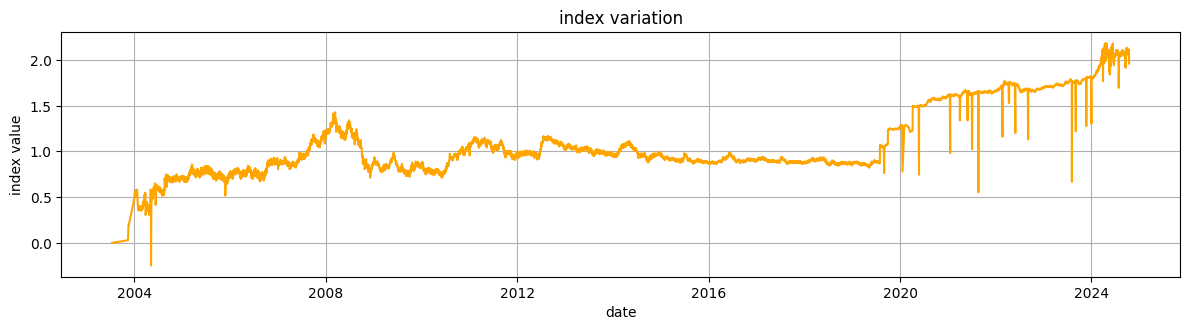

In [8]:
plot_variation(index_df,dc_name)

In [9]:
index_df.to_excel(f"outputs/result-{criteria_sheet}-{forindex_sheet}.xlsx")